In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import shapely
from rasterstats import zonal_stats

In [76]:
def make_grid(gdf, n_cells):
    gdf = gdf.copy()
    xmin, ymin, xmax, ymax=gdf.total_bounds
    cell_size = (xmax-xmin)/n_cells
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            x1=x0-cell_size
            y1=y0+cell_size
            grid_cells.append(shapely.geometry.box(x0,y0,x1,y1))
    grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs=gdf.crs)
    return grid

In [77]:
def rasterize(gdf, grid, aggfunc="count", column=None, plot=True):
    merged = gpd.sjoin(gdf, grid, how='left', predicate='within').copy()
    if aggfunc == "count":
        column = 'count'
        output_col = column
        merged[column] = 1
    else:
        output_col = column + "_" + aggfunc   
    dissolved = merged.dissolve(by="index_right", aggfunc=aggfunc)[[column]]
    dissolved.columns = [output_col]
    grid.loc[dissolved.index, output_col] = dissolved[output_col].values
    if plot:
        ax = grid.plot(column=output_col, figsize=(12, 8), edgecolor="grey", legend=True)
        ax.axis('off')
        cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,crs=gdf.crs)
        plt.show()
    return grid

In [78]:
dfr = pd.read_csv("../Data/Raw/Boston22ArrestData.csv")
dfr['OCCURRED_ON_DATE'] = pd.to_datetime(dfr['OCCURRED_ON_DATE'])
dfr = dfr.set_index('OCCURRED_ON_DATE').between_time('06:00', '20:00')
dfr = dfr.query("Lat >= 42.225 and Lat <= 42.4")
dfr = dfr.query("Long >= -71.2 and Long <= -70.99")
dfr

/var/folders/r5/h1j70sn57kb62lz4pb44g9000000gn/T/ipykernel_3089/98535092.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv("../Data/Raw/Boston22ArrestData.csv")


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
OCCURRED_ON_DATE,,,,,,,,,,,,,,,,
2022-01-01 06:16:00,222000081,423,NaN,ASSAULT - AGGRAVATED,E18,,0,2022,1,Saturday,6,NaN,WESTMINSTER ST,42.264413,-71.116190,"(42.264412911326176, -71.1161903826611)"
2022-01-01 06:19:00,222000079,3006,NaN,SICK/INJURED/MEDICAL - PERSON,A7,,0,2022,1,Saturday,6,NaN,HORACE ST,42.381550,-71.019002,"(42.3815497968431, -71.01900245855879)"
2022-01-01 06:24:00,222000078,1402,NaN,VANDALISM,C11,,0,2022,1,Saturday,6,NaN,NEWPORT ST,42.318025,-71.054041,"(42.31802518639054, -71.0540412151)"
2022-01-01 06:30:00,222000140,614,NaN,LARCENY THEFT FROM MV - NON-ACCESSORY,B2,,0,2022,1,Saturday,6,NaN,DEWEY ST,42.316662,-71.076343,"(42.31666169489078, -71.07634280646599)"
2022-01-01 06:41:00,222000080,1831,NaN,SICK ASSIST,C11,,0,2022,1,Saturday,6,NaN,BROOKVALE ST,42.278941,-71.065733,"(42.2789413704902, -71.0657329015908)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:44:00,222101053,613,NaN,LARCENY SHOPLIFTING,E13,,0,2022,12,Saturday,19,NaN,CENTRE ST,42.322914,-71.103284,"(42.32291406263416, -71.10328402059667)"
2022-12-31 19:50:00,232000375,613,NaN,LARCENY SHOPLIFTING,C11,355,0,2022,12,Saturday,19,NaN,GIBSON ST,42.297555,-71.059709,"(42.29755532959655, -71.05970910242573)"
2022-12-31 20:00:00,232000133,3201,NaN,PROPERTY - LOST/ MISSING,E13,574,0,2022,12,Saturday,20,NaN,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)"


In [79]:
CrimeTypes = {}
CT = []

for row in dfr['OFFENSE_DESCRIPTION']:
    if row not in CrimeTypes:
        CrimeTypes[row]=0
    CrimeTypes[row]+=1

CDF = pd.DataFrame.from_dict(CrimeTypes, orient ='index')
CDF.reset_index(inplace=True)
CDF = CDF.rename(columns = {'index':'Crime_Type',0:'Count'})
CDF = CDF.sort_values(by='Count',ascending=False)
CDF = CDF.reset_index(drop=True)

In [80]:
crime_lables = {}
for a in CDF['Crime_Type']:
    if 'M/V' in a and a != 'INJURY BICYCLE NO M/V INVOLVED':
        crime_lables[a] = 'M/V ACCIDENT'
    elif 'DRUGS' in a:
        crime_lables[a] = 'DRUGS'
    elif 'DRUNK' in a:
        crime_lables[a] = 'DRUGS'
    elif 'ALCOHOL' in a:
        crime_lables[a] = 'DRUGS'
    elif 'ASSAULT' in a:
        crime_lables[a] = 'ASSAULT'
    elif 'AUTO THEFT' in a:
        crime_lables[a] = 'LOST MOTOR VEHICLE'
    elif 'FIRE REPORT' in a:
        crime_lables[a] = 'EMERGANCY SERVICES'
    elif 'SICK' in a:
        crime_lables[a] = 'EMERGANCY SERVICES'
    elif 'MISSING PERSON' in a:
        crime_lables[a] = 'MISSING PERSON'
    elif a == 'TOWED MOTOR VEHICLE':
        crime_lables[a] = 'LOST MOTOR VEHICLE'
    elif a == 'VERBAL DISPUTE':
        crime_lables[a] = 'VERBAL DISPUTE'
    elif a == 'THREATS TO DO BODILY HARM':
        crime_lables[a] = 'THREATS TO DO BODILY HARM'
    else:
        crime_lables[a] = 'OTHER'

In [81]:
df =dfr.copy()
df['OFFENSE_GROUP'] = df['OFFENSE_DESCRIPTION'].apply(lambda x: crime_lables[x])

In [82]:
MCrimeTypes = {}
CT = []

for row in df['OFFENSE_GROUP']:
    if row not in MCrimeTypes:
        MCrimeTypes[row]=0
    MCrimeTypes[row]+=1

MCDF = pd.DataFrame.from_dict(MCrimeTypes, orient ='index')
MCDF.reset_index(inplace=True)
MCDF = MCDF.rename(columns = {'index':'Crime_Type',0:'Count'})
MCDF = MCDF.sort_values(by='Count',ascending=False)
MCDF = MCDF.reset_index(drop=True)
MCDF

,Crime_Type,Count
0,OTHER,25270
1,M/V ACCIDENT,7224
2,EMERGANCY SERVICES,5278
3,LOST MOTOR VEHICLE,3174
4,ASSAULT,2561
5,DRUGS,1274
6,VERBAL DISPUTE,1178
7,THREATS TO DO BODILY HARM,1108
8,MISSING PERSON,1096


In [83]:
geoms = gpd.points_from_xy(df['Long'], df['Lat'])
gdf = gpd.GeoDataFrame(df, geometry=geoms)
gdf.crs = 4326
gdf.to_file('../Data/Transformed/gdf.geojson', driver="GeoJSON")  

In [84]:
grid = make_grid(gdf, n_cells=39)
grid['id'] = grid.index+1
grid

,geometry,id
0,"POLYGON ((-71.18334 42.23266, -71.18334 42.237...",1
1,"POLYGON ((-71.18334 42.23732, -71.18334 42.241...",2
2,"POLYGON ((-71.18334 42.24198, -71.18334 42.246...",3
3,"POLYGON ((-71.18334 42.24665, -71.18334 42.251...",4
4,"POLYGON ((-71.18334 42.25131, -71.18334 42.255...",5
...,...,...
1471,"POLYGON ((-70.99677 42.37725, -70.99677 42.381...",1472
1472,"POLYGON ((-70.99677 42.38191, -70.99677 42.386...",1473
1473,"POLYGON ((-70.99677 42.38658, -70.99677 42.391...",1474
1474,"POLYGON ((-70.99677 42.39124, -70.99677 42.395...",1475


In [85]:
popr = '../Data/Raw/BostonPop'
stats = gpd.GeoDataFrame(zonal_stats(grid, popr, stats=["sum"]))
grid = grid.join(stats)
grid = grid.rename(columns={'sum': 'Pop'})

/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in

In [86]:
dfsjoin = gpd.sjoin(grid, gdf) #Spatial join Points to polygons
dfpivot = pd.pivot_table(dfsjoin,index='id',columns='OFFENSE_GROUP',aggfunc={'OFFENSE_GROUP':len})
dfpivot.columns = dfpivot.columns.droplevel()
grida = grid.merge(dfpivot, how='left', on='id')
grida['TOTAL'] = 0
for a in MCDF.sort_values('Crime_Type')['Crime_Type']:
    grida[a] = grida[a].replace(np.NaN, 0.0)
    grida[f'{a} RATE'] = grida[a]/grida['Pop']
    grida[f'{a} RATE'] = grida[f'{a} RATE'].replace([np.NaN,np.inf], 0.0)
grida['TOTAL'] = grida.iloc[:, 3:12].sum(axis=1)
grida['TOTAL RATE'] = grida['TOTAL']/grida['Pop']
grida['TOTAL RATE'] = grida['TOTAL RATE'].replace([np.NaN,np.inf], 0.0)

In [87]:
for a in grida:
    if 'RATE' in a:
        grida.loc[grida['Pop']<50, a] = 0

In [88]:
grida.to_file('../Data/Transformed/grida.geojson', driver="GeoJSON")  

In [89]:
Landmarks = gpd.read_file("../Data/Raw/Boston_Landmarks_Commission_(BLC)_Landmarks.zip")
band = Landmarks[['PID_LONG','Name_of_Pr','ShapeSTAre','ShapeSTLen','geometry']].copy()
band['geometry'] = Landmarks.to_crs(6933).buffer(50).to_crs(4326)
Landmarks['x'] = Landmarks['geometry'].to_crs(26986).centroid.to_crs(4326).x
Landmarks['y'] = Landmarks['geometry'].to_crs(26986).centroid.to_crs(4326).y

/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in geom.type:
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/rasterstats/main.py:156: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Point' in

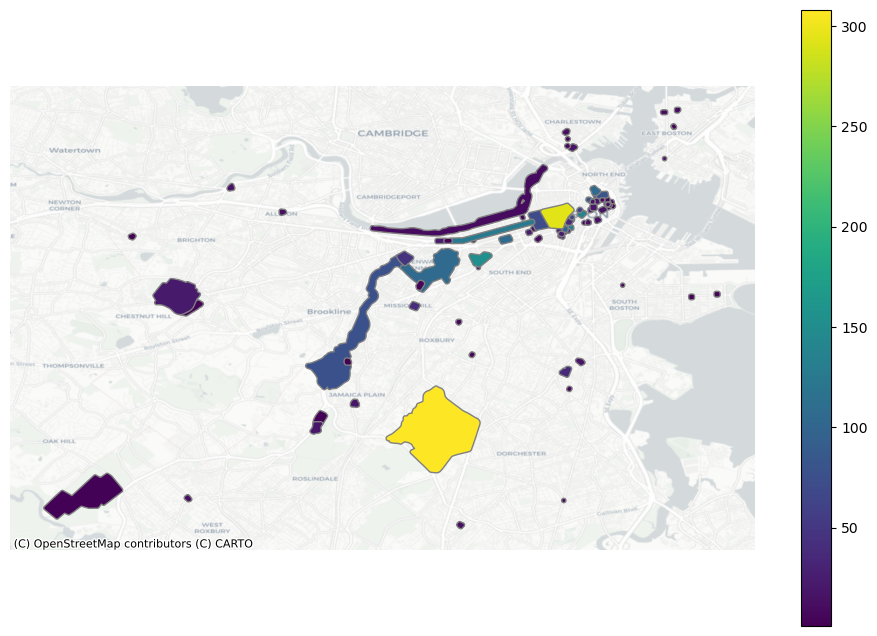

/opt/anaconda3/envs/info615/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/info615/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [90]:
stats = gpd.GeoDataFrame(zonal_stats(band, popr, stats=["sum"]))
band = band.join(stats)
band = band.rename(columns={'sum': 'Pop'})
r = rasterize(gdf,band,aggfunc="count")
r['count'] = r['count'].replace([np.NaN,np.inf], 0.0)
r['Pop'] = r['Pop'].replace([np.NaN,np.inf], 0.0)
r = r[r['PID_LONG']!= '1902802000']
r['RATE'] = r['count']/r['Pop']
r['ARATE'] = r['RATE']/r['ShapeSTAre']

In [91]:
Landmarks = Landmarks.merge(r.iloc[:,[1,5,6,7,8]], how='left', on='Name_of_Pr')
Landmarks = Landmarks.sort_values('RATE',ascending=False)

In [92]:
Landmarks.to_file('../Data/Transformed/Landmarks.geojson', driver="GeoJSON")  